<a href="https://colab.research.google.com/github/gd-zhang/noisy-quadratic-model/blob/master/nqm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demo code for "[Which Algorithmic Choices Matter at Which Batch Sizes? Insights From a Noisy Quadratic Model.](https://arxiv.org/abs/1905.00414)"

Please cite as:

    @inproceedings{zhang2019algorithmic,
      title={Which algorithmic choices matter at which batch sizes? insights from a noisy quadratic model},
      author={Zhang, Guodong and Li, Lala and Nado, Zachary and Martens, James and Sachdeva, Sushant and Dahl, George E and Shallue, Christopher J and Grosse, Roger},
      booktitle={Advances in Neural Information Processing Systems},
      year={2019}
    }

In [0]:
from autograd import numpy as np
from autograd import grad
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as real_np
import math
import time
import scipy.optimize

import warnings
warnings.filterwarnings('ignore')

## **Setup and Details**

We'll consider the toy problem of minimizing a noisy quadratic function $\tfrac{1}{2}x^T H x$, where $H$ is a diagonal matrix, and the gradient noise has covariance $H$ (with the idea that the gradient covariance is approximately the Fisher matrix, which is approximately the Hessian). You can think of this problem as maximum likelihood estimation the mean parameters of a multivariate Gaussian from samples.

The diagonal entries of $H$ will be $\{\frac{1}{i}\}_{i=1}^K$ for some integer $K$. Notice that $K$ is the condition number of this objective. This distribution is somewhat representative of the eigenspectrum of the Hessian of a neural net, which has a small number of large eigenvalues and a large number of small ones. I chose $K=10^4$, since this seems roughly consistent with the eigenspectra Lala observed for the K-FAC Fisher matrix.

We initialize $x$ as $\mathcal{N}(0, I)$. (The results don't seem to be sensitive to the initial variance.) Since SGD is a linear operation, it preserves the Gaussianity of $x$, and also its mean of $0$. Hence, the state of the system after any number of SGD updates can be represented as a zero-centered Gaussian with diagonal covariance $S = \mathrm{diag}(s_1, \ldots, s_n)$. The loss at any given time is given by $\tfrac{1}{2} \sum_{i=1}^D h_i s_i$. Hence, in order to model the dynamics of SGD, we simply need to model the evolution of the $s_i$.

Each dimension evolves independently as $$s_i^{(t+1)} = (1-\alpha h_i)^2 s_i^{(t)} + \alpha^2 \sigma_i^2,$$ where $\sigma^2$ is the gradient noise variance. Since we assume the variance for each individual example is given by $h_i$, the variance for the batch will be $\sigma_i^2 = h_i / B$, where $B$ is the batch size. Based on this recurrence, we can also simulate $k$ steps of SGD with a fixed learning rate analytically:
$$\begin{aligned} \beta_i &= (1 - \alpha h_i)^2 \\ s_* &= \frac{\alpha^2 \sigma_i^2}{1 - \beta} \\ s_t &= s_* + \beta_i^k(s_0 - s_*).\end{aligned}$$

For efficiency, rather than explicitly representing all the eigenvalues of $H$, we quantize them into 100 bins and count the number of eigenvalues in each bin.

One of the things we're interested in is how much of a gain we get from having a better preconditioner. I'll consider preconditioners of the form $H^{-\gamma}$ for $0 \leq \gamma \leq 1$, with $\gamma=1$ being the ideal preconditioner. This doesn't correspond to any algorithms we actually use, but larger values of $\gamma$ reduce the condition number by a larger factor, so we can treat larger $\gamma$ as a proxy for a more accurate preconditioner (e.g. K-FAC) and smaller values of $\gamma$ as a proxy for a less accurate one.

In [0]:
def toy_problem(ndim, nbins):
  """Determine the values and counts for the discretized eigenvalues for our toy problem."""
  full_h = 1.0 / real_np.arange(1, ndim+1)
  bins = real_np.geomspace(full_h[0], full_h[-1], nbins)
    
  curr_bin = 0
  i = 0
  counts = real_np.zeros(nbins)
  while i < ndim:
    while i < ndim and full_h[i] >= bins[curr_bin]:
      counts[curr_bin] += 1
      i += 1
    curr_bin += 1
        
  return bins, counts

def loss(h, s, counts=None):
  if counts is None:
    counts = np.ones_like(h)
  return 0.5 * np.sum(h * s * counts)

def simulate_kstep_dynamics(h, sigma_sq, s_init, lrate, k, prec=None):
  """Simulate k steps of SGD as described above."""
  h = np.array(h)
  sigma_sq = np.array(sigma_sq)
  s_init = np.array(s_init)
    
  if prec is None:
    prec = np.ones_like(h)
  beta = (1 - lrate*prec*h)**2
  s_star = (prec*lrate)**2 * sigma_sq / (1 - beta + 1e-8)
  return s_star + beta**k * (s_init - s_star)

def training_curve(h, sigma_sq, s_init, lrate, num_steps, counts=None, prec=None):
  losses = []
  for k in range(num_steps):
    s = simulate_kstep_dynamics(h, sigma_sq, s_init, lrate, k, prec=prec)
    losses.append(loss(h, s, counts))
  return losses


def time_to_loss(h, sigma_sq, s_init, lrate, C, counts=None, prec=None):
  """Determine the time it takes to reach loss C using a given fixed learning rate. Uses binary search."""
  high = 1000000000
  low = 0
    
  while low < high - 1:
    mid = int(math.floor((low + high) / 2))
        
    s = simulate_kstep_dynamics(h, sigma_sq, s_init, lrate, mid, prec=prec)
    L = loss(h, s, counts)
    if L < C:
      high = mid
    else:
      low = mid
  return max(low, 1)

def optimal_ttl(h, sigma_sq, s_init, C, counts=None, prec=None, return_lrate=False):
  """Do a grid search over (fixed) learning rates to find the shortest time it takes to reach loss C."""
  lrates = np.logspace(-5, 0.5, 100)
  best = np.infty
  best_lrate = 0.0
  for lrate in lrates:
    ttl = time_to_loss(h, sigma_sq, s_init, lrate, C, counts=counts, prec=prec)
    if ttl < best:
      best = ttl
      best_lrate = lrate
  if return_lrate:
    return best, best_lrate

  return best

### **Simulate PWC learning rate scheme**

In [0]:
def simulate_pwc_dynamics(h, sigma_sq, s_init, lrates, ks, prec=None):
  """Simulate SGD with a piecewise constant schedule. lrates and ks are arrays of the same size,
  and each segment corresponds to k steps of SGD with the given learning rate."""
  s = s_init
  for lrate, k in zip(lrates, ks):
    s = simulate_kstep_dynamics(h, sigma_sq, s, lrate, k, prec=prec)
  return s

def eval_pwc_schedule(h, sigma_sq, s_init, log_lrates, ks, counts, prec):
  s = simulate_pwc_dynamics(h, sigma_sq, s_init, np.exp(log_lrates), ks, prec)
  return loss(h, s, counts)

def optimize_lrates(h, sigma_sq, s_init, ks, counts, prec, max_llr):
  """Determine the optimal piecewise constant learning rate schedule."""
  npc = ks.size
  init_llr = -5 * np.ones(npc)
    
  fn_wrap = lambda llr: eval_pwc_schedule(h, sigma_sq, s_init, llr, ks, counts, prec)
  grad_eval_pwc_schedule = grad(eval_pwc_schedule, 3)
  grad_wrap = lambda llr: grad_eval_pwc_schedule(h, sigma_sq, s_init, llr, ks, counts, prec)
    
  bounds = scipy.optimize.Bounds(-np.infty, max_llr)
  res = scipy.optimize.minimize(fn_wrap, init_llr, jac=grad_wrap, bounds=bounds)
  return res.x
    

def ttl_sched(h, sigma_sq, s_init, C, counts, prec, npc, max_llr, return_lrate=False):
  """Determine the smallest number of steps needed to reach loss C using an optimal piecewise
  constant schedule. Uses binary search, testing if C is achievable in a given number of steps."""
  high = 100000000
  low = 0
    
  while low < high - 1:
    mid = int(math.floor((low + high) / 2))
        
    ks = mid * np.ones(npc, dtype=int)
    log_lrates = optimize_lrates(h, sigma_sq, s_init, ks, counts, prec, max_llr)
    s = simulate_pwc_dynamics(h, sigma_sq, s_init, np.exp(log_lrates), ks, prec=prec)
    L = loss(h, s, counts)
    if L < C:
      high = mid
    else:
      low = mid
  low = np.maximum(low, 1)
  if return_lrate:
    return low, np.exp(log_lrates)

  return low

### **Simulate Momentum SGD**

In [0]:
def simulate_momentum_dynamics(h, sigma_sq, s_init, lrate, k, momentum=0.0, prec=None):
  """Simulate k steps of SGD with momentum as described above."""
  ndim = h.size
  h = np.array(h)
  sigma_sq = np.array(sigma_sq)
    
  init_p = np.zeros((ndim, 3))
  init_p[:, 0] = np.array(s_init)
    
  if prec is None:
    prec = np.ones_like(h)
  x = lrate*prec*h
  noise = np.ones((ndim, 3)) * np.tile(np.expand_dims((prec*lrate)**2 * sigma_sq, axis=1), (1, 3))
    
  # defining the transition matrix
  trans_mat = np.zeros((ndim, 3, 3))
  trans_mat[:, :, 1] = momentum ** 2
  trans_mat[:, 0, 0] = (1 - x) ** 2
  trans_mat[:, 1, 0] = x ** 2
  trans_mat[:, 2, 0] = - (1 - x) * x
  trans_mat[:, 0, 2] = 2 * (1 - x) * momentum
  trans_mat[:, 1, 2] = -2 * x * momentum
  trans_mat[:, 2, 2] = (1 - 2 * x) * momentum
    
  # eigen-decomposition
  e, v = np.linalg.eig(trans_mat)
  v_inv = np.linalg.inv(v)
    
  trans_init_p = np.squeeze(np.matmul(v_inv, np.expand_dims(init_p, axis=2)))
  trans_noise = np.squeeze(np.matmul(v_inv, np.expand_dims(noise, axis=2)))
    
  p_star = trans_noise / (1 - e)
    
  trans_final_p = e ** k * (trans_init_p - p_star) + p_star
  final_p = np.squeeze(np.matmul(v, np.expand_dims(trans_final_p, axis=2)))
    
  return final_p[:, 0].real
  
def time_to_loss_wm(h, sigma_sq, s_init, lrate, momentum, C, counts=None, prec=None):
  """Determine the time it takes to reach loss C using a given fixed learning rate and momentum value. Uses binary search."""
  high = 10000000
  low = 0
    
  while low < high - 1:
    mid = int(math.floor((low + high) / 2))
        
    s = simulate_momentum_dynamics(h, sigma_sq, s_init, lrate, mid, momentum=momentum, prec=prec)
    L = loss(h, s, counts)
    if L < C:
      high = mid
    else:
      low = mid
    
  return low

def optimal_ttl_wm(h, sigma_sq, s_init, C, counts=None, prec=None, momentum=None, return_lrate=False, return_momentum=False):
  """Do a grid search over (fixed) learning rates and momentum coefficients to find the shortest time it takes to reach loss C."""
  lrates = np.logspace(-8, 1, 100)

  if momentum is None:
    momentums = 1 - np.logspace(-5, 0, 20)
  else:
    momentums = [momentum]
  best = np.infty
  best_lrate = 0.0
  best_momentum = 0.0
  for lrate in lrates:
    for momentum in momentums:
      ttl = time_to_loss_wm(h, sigma_sq, s_init, lrate, momentum, C, counts=counts, prec=prec)
      if ttl < best:
        best = ttl
        best_lrate = lrate
        best_momentum = momentum
  if return_lrate:
    if return_momentum:
      return best, best_lrate, best_momentum
    return best, best_lrate
  return best

### **Simulate Exponential Moving Average**

In [0]:
def simulate_ema_dynamics(h, sigma_sq, s_init, lrate, k, decay=0.0, prec=None):
  """Simulate k steps of SGD with exponential moving average."""
  ndim = h.size
  h = np.array(h)
  sigma_sq = np.array(sigma_sq)
    
  init_p = np.zeros((ndim, 3))
  init_p[:, 0] = np.array(s_init)
  init_p[:, 1] = np.array(s_init) / (1 - decay) ** 2
  init_p[:, 2] = np.array(s_init) / (1 - decay)
    
  if prec is None:
    prec = np.ones_like(h)
  x = lrate*prec*h
  noise = np.ones((ndim, 3)) * np.tile(np.expand_dims((prec*lrate)**2 * sigma_sq, axis=1), (1, 3))
    
  # defining the transition matrix
  trans_mat = np.zeros((ndim, 3, 3))
  trans_mat[:, :, 0] = np.tile(np.expand_dims((1 - x) ** 2, axis=1), (1, 3))
  trans_mat[:, 1, 1] = decay ** 2
  trans_mat[:, 1, 2] = 2 * decay * (1 - x)
  trans_mat[:, 2, 2] = decay * (1 - x)
    
  # eigen-decomposition
  e, v = np.linalg.eig(trans_mat)
  v_inv = np.linalg.inv(v)
    
  trans_init_p = np.squeeze(np.matmul(v_inv, np.expand_dims(init_p, axis=2)))
  trans_noise = np.squeeze(np.matmul(v_inv, np.expand_dims(noise, axis=2)))
    
  p_star = trans_noise / (1 - e)
    
  trans_final_p = e ** k * (trans_init_p - p_star) + p_star
  final_p = np.squeeze(np.matmul(v, np.expand_dims(trans_final_p, axis=2)))
    
  return final_p[:, 1].real * (1 - decay) ** 2
  
def time_to_loss_ema(h, sigma_sq, s_init, lrate, decay, C, counts=None, prec=None):
  """Determine the time it takes to reach loss C using a given fixed learning rate and decay coefficent. Uses binary search."""
  high = 10000000
  low = 0
    
  while low < high - 1:
    mid = int(math.floor((low + high) / 2))
        
    s = simulate_ema_dynamics(h, sigma_sq, s_init, lrate, mid, decay=decay, prec=prec)
    L = loss(h, s, counts)
    if L < C:
      high = mid
    else:
      low = mid
    
  return low

def optimal_ttl_ema(h, sigma_sq, s_init, C, counts=None, prec=None, decay=None, return_lrate=False, return_decay=False):
  """Do a grid search over (fixed) learning rates and decay coefficients to find the shortest time it takes to reach loss C."""
  lrates = np.logspace(-8, 1, 100)

  if decay is None:
    decays = 1 - np.logspace(-5, 0, 20)
  else:
    decays = [decay]
  best = np.infty
  best_lrate = 0.0
  best_decay = 0.0
  for lrate in lrates:
    for decay in decays:
      ttl = time_to_loss_ema(h, sigma_sq, s_init, lrate, decay, C, counts=counts, prec=prec)
      if ttl < best:
        best = ttl
        best_lrate = lrate
        best_decay = decay
  if return_lrate:
    if return_decay:
      return best, best_lrate, best_decay
    return best, best_lrate
  return best

### **Init plot setting**

In [0]:
plt.style.use('classic')
def init_plotting():
  plt.rcParams['figure.figsize'] = (10, 7)
  plt.rcParams['pdf.fonttype'] = 42
  plt.rcParams['font.size'] = 18
  plt.rcParams['axes.labelsize'] = 1.5 * plt.rcParams['font.size']
  plt.rcParams['axes.titlesize'] = 1.5 * plt.rcParams['font.size']
  plt.rcParams['axes.grid']=  True
  plt.rcParams['legend.fontsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['xtick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams['ytick.labelsize'] = 1.2 * plt.rcParams['font.size']
  plt.rcParams["legend.framealpha"] = 0.7
  plt.rcParams['lines.linewidth'] = 3.0
  plt.rcParams['lines.markersize'] = 10

sns.set()
init_plotting()

colors = ["r", "g", "b", "c"]

### **Training curves**

We plot some SGD training curves to get a sense of the short-term/long-term tradeoff in choosing learning rates. As argued in our paper, large learning rate leads to fast convergence at the expense of high steady state risk.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


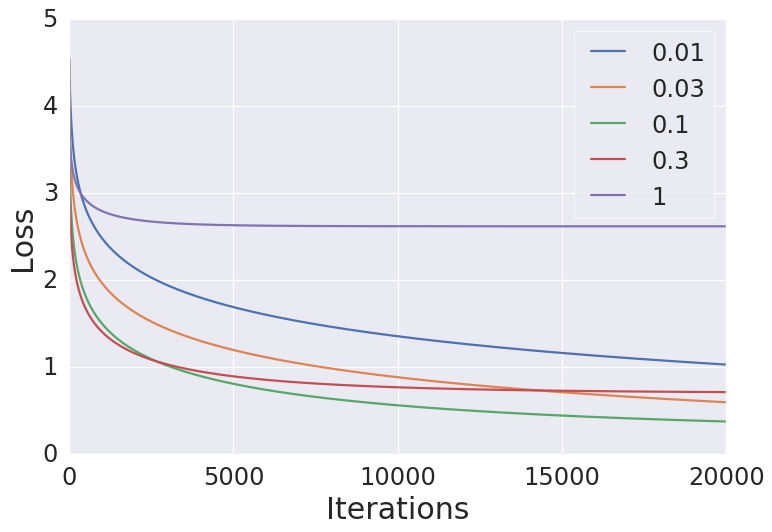

In [0]:
NUM_STEPS = 20000
NDIM = 5000
INIT_DIST = 1

h = 1.0 / real_np.arange(1, NDIM+1)
sigma_sq = h
s_init = INIT_DIST * real_np.ones(NDIM)

plt.figure()
for lrate in [1e-2, 3e-2, 1e-1, 3e-1, 1]:
  tc = training_curve(h, sigma_sq, s_init, lrate, NUM_STEPS)
  plt.plot(tc, linewidth=2, label=str(lrate))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()

### **Effect of loss threshold**

The shape of the curves is reasonably consistent for different loss thresholds, though the transition from the stochastic to determinstic regime seems to occur at a larger batch size for tougher thresholds.

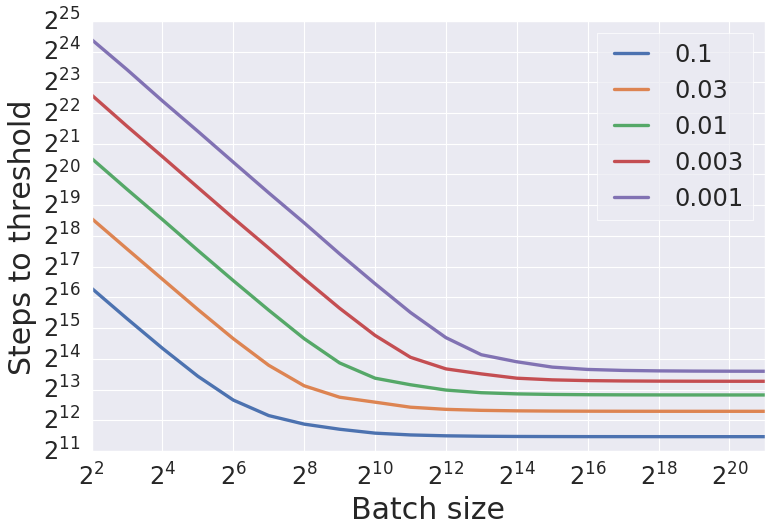

In [0]:
BATCH_SIZES = 2 ** np.arange(2, 22)

NDIM = 10000
NBINS = 100
INIT_DIST = 1

h, counts = toy_problem(NDIM, NBINS)
s_init = INIT_DIST * np.ones(NBINS)

plt.figure()

for C in [0.1, 0.03, 0.01, 0.003, 0.001]:
  Ts = []
  for bs in BATCH_SIZES:
    sigma_sq = h / bs
    T = optimal_ttl(h, sigma_sq, s_init, C, counts=counts)
    Ts.append(T)
  plt.loglog(BATCH_SIZES, Ts, label=str(C), basex=2, basey=2)
plt.xlabel('Batch size')
plt.ylabel('Steps to threshold')
plt.tight_layout()
plt.legend()

### **Optimal LR as a function of batch size**

We plot the optimal learning rate as a function of batch size so as to get a sense of the relationship between optimal learning rate and batch size. Interestingly, we find the optimal learning rates scale linearly with the batch sizes.

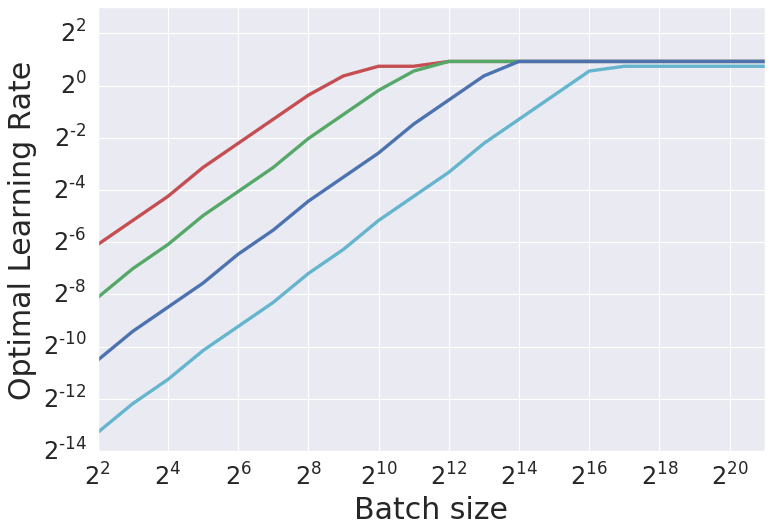

In [0]:
BATCH_SIZES = 2 ** np.arange(2, 22)

NDIM = 10000
NBINS = 100
INIT_DIST = 1

h, counts = toy_problem(NDIM, NBINS)
s_init = INIT_DIST * np.ones(NBINS)
C = 0.01

plt.figure()

for i, prec_pow in enumerate([0.0, 0.25, 0.5, 0.75]):
  lrates = []
  for bs in BATCH_SIZES:
    sigma_sq = h / bs
    prec = 1 / h ** prec_pow
    _, lr = optimal_ttl(h, sigma_sq, s_init, C, counts=counts, prec=prec, return_lrate=True)
    lrates.append(lr)
  plt.loglog(BATCH_SIZES, lrates, basex=2, basey=2, color=colors[i], label=str(prec_pow))
plt.ylim(2 ** (-14), 2 ** 3)
plt.xlabel('Batch size')
plt.ylabel('Optimal Learning Rate')
plt.tight_layout()

### **Optimal PWC Learning Rate as a function of batch size**

Learning rate decay is a popular trick in training neural networks. Here, we study the optimal piecewise constant learning rate scheme for different batch size. Interestingly, the optimal scheme always starts with the largest feasible learning rate.

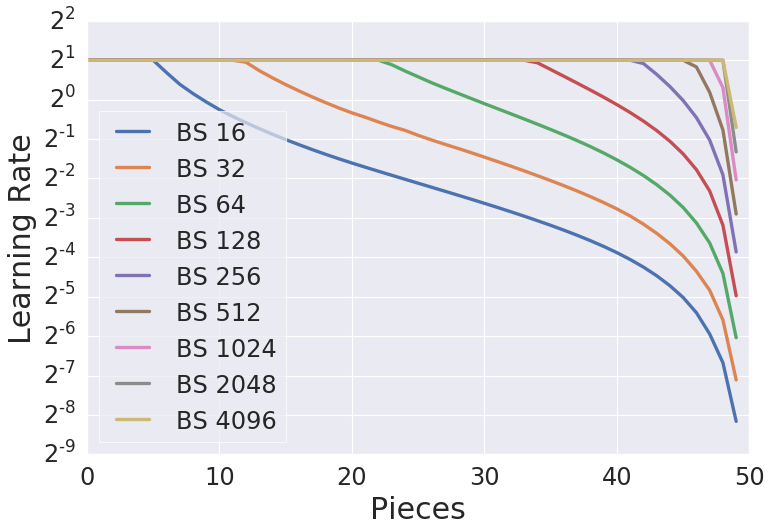

In [0]:
BATCH_SIZES = 2 ** np.arange(4, 13)

NDIM = 10000
NBINS = 100
INIT_DIST = 1

h, counts = toy_problem(NDIM, NBINS)
s_init = INIT_DIST * np.ones(NBINS)
C = 0.01

steps = []
final_lrates = []
lrates_list = []
for i, bs in enumerate(BATCH_SIZES):
  sigma_sq = h / bs
  step, lrates = ttl_sched(h, sigma_sq, s_init, C, counts, 1.0, 50, np.log(2.0/(1.0 + 10 ** (-4) + 1e-4)), return_lrate=True)
  lrates_list.append(lrates)
  # total_steps = np.arange(15) * step
  plt.semilogy(lrates, label="BS " + str(bs), basey=2)
  steps.append(step)
  final_lrates.append(lrates[-1])
plt.xlabel('Pieces')
plt.ylabel('Learning Rate')
plt.ylim(ymax=4)
plt.tight_layout()
plt.legend(loc=3)

### **Effect of momentum and preconditioning**

Here, we study the effect of momentum and preconditioning in batch size scaling. Particularly, we find that momentum (solid lines) accelerates training at large batch sizes as it allows us to use larger **effective learning rate**. However, it has little benefit at small batch sizes. On the other hand, preconditioning further extends perfect scaling to larger batch sizes. Furthermore, unlike momentum, preconditioning can help at small batch sizes as well.

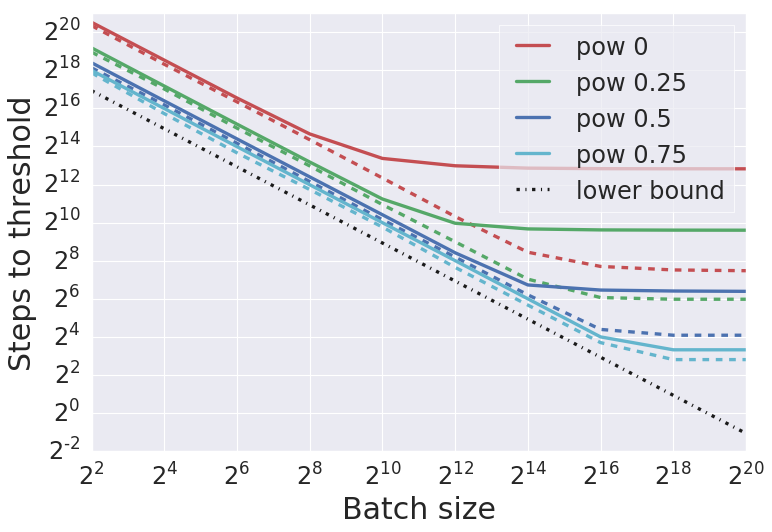

In [0]:
BATCH_SIZES = 2 ** np.arange(2, 22, 2)

NDIM = 10000
NBINS = 100
INIT_DIST = 1
C = 0.01

h, counts = toy_problem(NDIM, NBINS)
s_init = INIT_DIST * np.ones(NBINS)

colors = ["r", "g", "b", "c"]

momentums_list = []
lrates_1_list = []
lrates_2_list = []
Tss, Tss_m = [], []
for i, prec_pow in enumerate([0, 0.25, 0.5, 0.75]):
  Ts, Ts_m, lrates_1, lrates_2, momentums = [], [], [], [], []
  for bs in BATCH_SIZES:
    sigma_sq = h / bs
    prec = 1 / h ** prec_pow
    T, lrate_1 = optimal_ttl(h, sigma_sq, s_init, C, counts=counts, prec=prec, return_lrate=True)
    Ts.append(T)
    lrates_1.append(lrate_1)
    T_m, lrate_2, momentum = optimal_ttl_wm(h, sigma_sq, s_init, C, counts=counts, prec=prec, return_lrate=True, return_momentum=True)
    Ts_m.append(T_m)
    lrates_2.append(lrate_2)
    momentums.append(momentum)

  lrates_1_list.append(lrates_1)
  lrates_2_list.append(lrates_2)
  momentums_list.append(momentums)
  plt.loglog(BATCH_SIZES, Ts, ls='-', color=colors[i], basex=2, basey=2, label="pow "+str(prec_pow))
  plt.loglog(BATCH_SIZES, Ts_m, ls='--', color=colors[i], basex=2, basey=2)
  Tss.append(Ts)
  Tss_m.append(Ts_m)
optimal = NDIM / (2*C*BATCH_SIZES)
plt.xlabel('Batch size')
plt.ylabel('Steps to threshold')
plt.loglog(BATCH_SIZES, optimal, 'k-.', basex=2, basey=2, label='lower bound')
plt.tight_layout()
plt.legend()

**Optimal Effective Learning Rate**

At small batch sizes, the optimal (effective) learning rates for plain SGD (dashed lines) and momentum SGD (solid lines) are roughly the same. But after a certain batch size, they start to diverge since plain SGD first hits the learning rate upper bound.

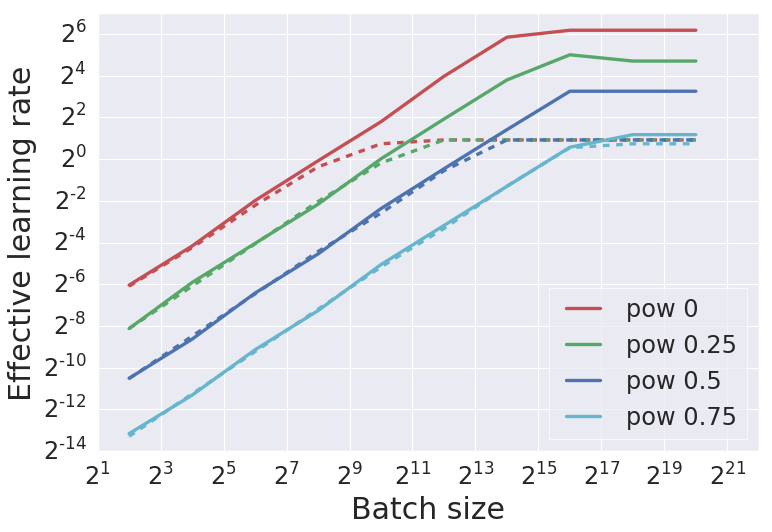

In [0]:
for i, (lrates_1, lrates_2, momentums, prec_pow) in enumerate(zip(lrates_1_list, lrates_2_list, momentums_list, [0, 0.25, 0.5, 0.75])):
  eff_lrates = [lrate/ (1 - momentum) for (lrate, momentum) in zip(lrates_2, momentums)]
  plt.loglog(BATCH_SIZES, lrates_1, basex=2, basey=2, color=colors[i], ls='--')
  plt.loglog(BATCH_SIZES, eff_lrates, basex=2, basey=2, color=colors[i], ls='-', label="pow " + str(prec_pow))

plt.ylim(2 ** (-14), 2 ** 7)
plt.xlabel('Batch size')
plt.ylabel('Effective learning rate')
plt.ylim(2 ** (-14), 2 ** 7)
plt.xlim(2 ** 1, 2 ** 22)
plt.tight_layout()
plt.legend(loc=4)

### **Effect of EMA**

As argued in the paper, EMA reduces the steady state risk without hurting the convergence rate. In this sense, it improves overall performance for a given batch size.

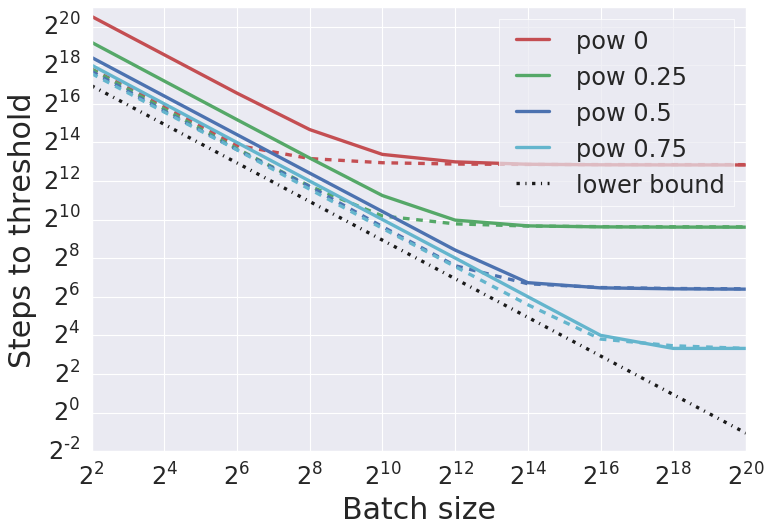

In [0]:
BATCH_SIZES = 2 ** np.arange(2, 22, 2)

NDIM = 10000
NBINS = 100
INIT_DIST = 1
C = 0.01

h, counts = toy_problem(NDIM, NBINS)
s_init = INIT_DIST * np.ones(NBINS)

colors = ["r", "g", "b", "c"]

decays_list = []
lrates_1_list = []
lrates_2_list = []
Tss, Tss_m = [], []
for i, prec_pow in enumerate([0, 0.25, 0.5, 0.75]):
  Ts, Ts_m, lrates_1, lrates_2, decays = [], [], [], [], []
  for bs in BATCH_SIZES:
    sigma_sq = h / bs
    prec = 1 / h ** prec_pow
    T, lrate_1 = optimal_ttl(h, sigma_sq, s_init, C, counts=counts, prec=prec, return_lrate=True)
    Ts.append(T)
    lrates_1.append(lrate_1)
    T_m, lrate_2, decay = optimal_ttl_ema(h, sigma_sq, s_init, C, counts=counts, prec=prec, return_lrate=True, return_decay=True)
    Ts_m.append(T_m)
    lrates_2.append(lrate_2)
    decays.append(decay)

  lrates_1_list.append(lrates_1)
  lrates_2_list.append(lrates_2)
  decays_list.append(decays)
  plt.loglog(BATCH_SIZES, Ts, ls='-', color=colors[i], basex=2, basey=2, label="pow "+str(prec_pow))
  plt.loglog(BATCH_SIZES, Ts_m, ls='--', color=colors[i], basex=2, basey=2)
  Tss.append(Ts)
  Tss_m.append(Ts_m)
optimal = NDIM / (2*C*BATCH_SIZES)
plt.xlabel('Batch size')
plt.ylabel('Steps to threshold')
plt.loglog(BATCH_SIZES, optimal, 'k-.', basex=2, basey=2, label='lower bound')
plt.tight_layout()
plt.legend()

### **Optimal Learning Rate for EMA**

In [0]:
for i, (lrates_1, lrates_2, decays, prec_pow) in enumerate(zip(lrates_1_list, lrates_2_list, decays_list, [0, 0.25, 0.5, 0.75])):
  # eff_lrates = [lrate/ (1 - decay) for (lrate, decay) in zip(lrates_2, decays)]
  plt.loglog(BATCH_SIZES, lrates_1, basex=2, basey=2, color=colors[i], ls='--')
  plt.loglog(BATCH_SIZES, lrates_2, basex=2, basey=2, color=colors[i], ls='-', label="pow " + str(prec_pow))

plt.ylim(2 ** (-14), 2 ** 3)
plt.xlabel('Batch size')
plt.ylabel('Learning rate')
plt.ylim(2 ** (-14), 2 ** 3)
plt.xlim(2 ** 1, 2 ** 22)
plt.tight_layout()
plt.legend(loc=4)

### **Optimal learning rate schedules.**

Here we consider optimal piecewise constant learning rate schedules with 10 pieces. Learning rate schedules can make a big difference in the stochastic regime. We also plot the information theoretic optimal loss (dashed black line). Dashed curves = optimal fixed learning rate, solid curves = optimized PWC schedule.

Learning rate schedules seem to close most of the gap between the fixed LR performance and the information theoretic optimum. (And it might be that more flexible LR schedules would be exactly optimal.) But they make no difference in the deterministic setting, i.e. for large batches, you might as well use a fixed LR.


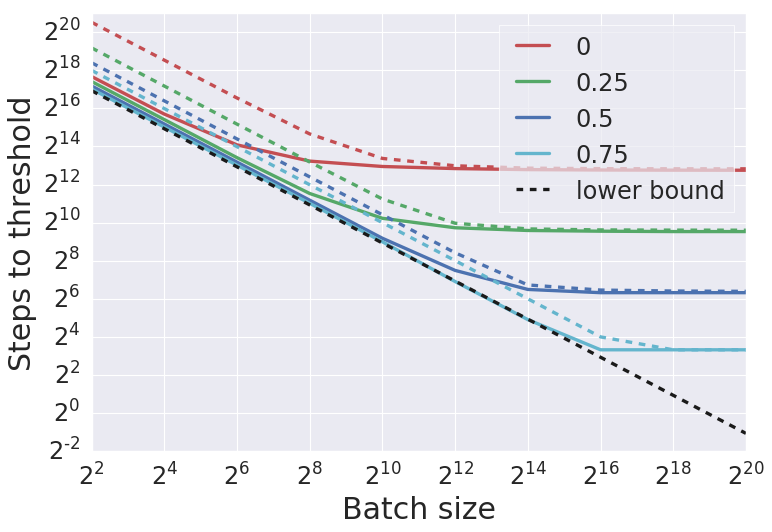

In [0]:
BATCH_SIZES = 2 ** np.arange(2, 22, 2)

NDIM = 10000
NBINS = 100
NPC = 10
INIT_DIST = 1
C = 0.01

h, counts = toy_problem(NDIM, NBINS)
s_init = INIT_DIST * np.ones(NBINS)
Tss_fixed, Tss_sched = [], []
for i, prec_pow in enumerate([0, 0.25, 0.5, 0.75]):
  Ts_fixed, Ts_sched = [], []
  for bs in BATCH_SIZES:
    sigma_sq = h / bs
    prec = 1 / h ** prec_pow
    T_fixed = optimal_ttl(h, sigma_sq, s_init, C, counts=counts, prec=prec)
    Ts_fixed.append(T_fixed)
    T_sched = NPC * ttl_sched(h, sigma_sq, s_init, C, counts, prec, NPC, np.log(2.0/(1.0 + 10 ** (-4 * (1.0 - prec_pow)) + 1e-4)))
    Ts_sched.append(T_sched)
  plt.loglog(BATCH_SIZES, Ts_fixed, color=colors[i], basex=2, basey=2, ls='--')
  plt.loglog(BATCH_SIZES, Ts_sched, color=colors[i], basex=2, basey=2, ls='-', label=str(prec_pow))
  Tss_fixed.append(Ts_fixed)
  Tss_sched.append(Ts_sched)
optimal = NDIM / (2*C*BATCH_SIZES)
plt.xlabel('Batch size')
plt.ylabel('Steps to threshold')
plt.loglog(BATCH_SIZES, optimal, 'k--', basex=2, basey=2, label='lower bound')
plt.legend()
plt.tight_layout()